In [2]:
import cv2 # pip3 install opencv-python
import numpy as np
from matplotlib import pyplot as plt
from skimage.util.shape import view_as_windows
from skimage.io import imread
from PIL import Image, ImageDraw # pip4 install Pillow
import json
import os
import math

In [44]:
def view(im, i=500):
    if isinstance(im, np.ndarray):
        im = Image.fromarray(im)
    im.thumbnail((i,i))
    return im

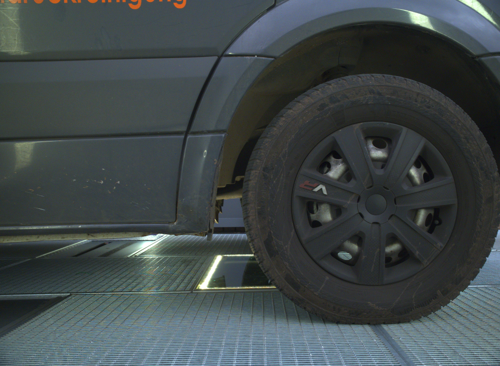

In [24]:
rel_data_path = "../sample_data/"
test_name = "2020-03-11+15-04-20+NAB972-Seite+Rechts+Unten-_00053"

im = imread(os.path.join(rel_data_path, test_name + ".jpg"))
view(im)

In [150]:
# Creates a simple image to better visualise overlapping
# you could do that using PIL's Image.putpixel, one by one, but it's 50 times slower, I tried
im = np.ones((3000, 4096, 3), dtype=np.uint8)
im[:,:,1] = 128
im[:,:,0] = np.repeat(np.linspace(0,256,4096)[..., None], 3000, axis=1).T
im[:,:,2] = np.repeat(np.linspace(0,256,3000)[..., None].T, 4096, axis=0).T
im_pil = Image.fromarray(im)

PIL image size:  (4096, 3000)
NP array shape:  (3000, 4096, 3)
Keep that in mind !


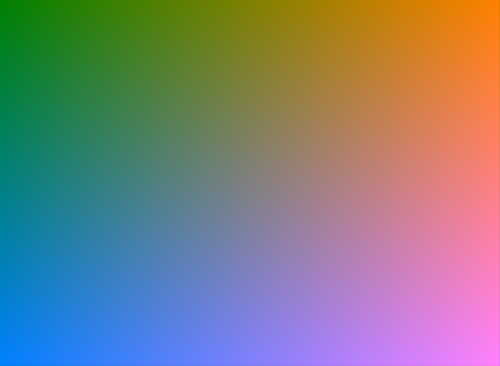

In [151]:
print("PIL image size: ", im_pil.size)
im = np.array(im_pil)
print("NP array shape: ", im.shape)
print("Keep that in mind !")
view(im)

In [152]:
im.shape

(3000, 4096, 3)

In [181]:
# In PIL, images sizes are (width, height) like normal
# But in Numpy, array are indexed (line, column), because that's how maths work
# Hence a 4096x3000 image is an array of shape (3000, 4096)
w_size = (500, 500)  # height,width
overlap = (400, 400) # height,width

In [182]:
windows = view_as_windows(im, (*w_size, 3), (w_size[0]-overlap[0], w_size[1]-overlap[1], 1)).squeeze()

In [183]:
windows.shape

(26, 36, 500, 500, 3)

In [184]:
def put_back_together(windows):
    # windows: Tensor[i,j, w_size[0], w_size[1], 3]
    count_h, count_w, win_h, win_w, _ = windows.shape
    im = Image.new("RGB", (count_w*win_w, count_h*win_h))
    for i in range(count_h):
        for j in range(count_w):
            im.paste(Image.fromarray(windows[i,j]), box=(j*win_w, i*win_h))
    return im

In [185]:
for name, i in zip(["height", "width"], range(2)):
    print("##", name)
    w, o, h = w_size[i], overlap[i], im.shape[i]
    step = w-o
    number_of_windows = (h-w)//step + 1 # Proved by testing, like a true engineer
    lost_border = h - (h//step * step)
    output_size = number_of_windows * w
    print("Losing ", lost_border, "px")
    print("Output size of ", output_size, "px")
    print(f"Increased input by {output_size-h}px ~ {output_size/h-1:.2%}")

## height
Losing  0 px
Output size of  13000 px
Increased input by 10000px ~ 333.33%
## width
Losing  96 px
Output size of  18000 px
Increased input by 13904px ~ 339.45%


Original	 (4096, 3000)
Frankenstein	 (18000, 13000)
439.45% 433.33%


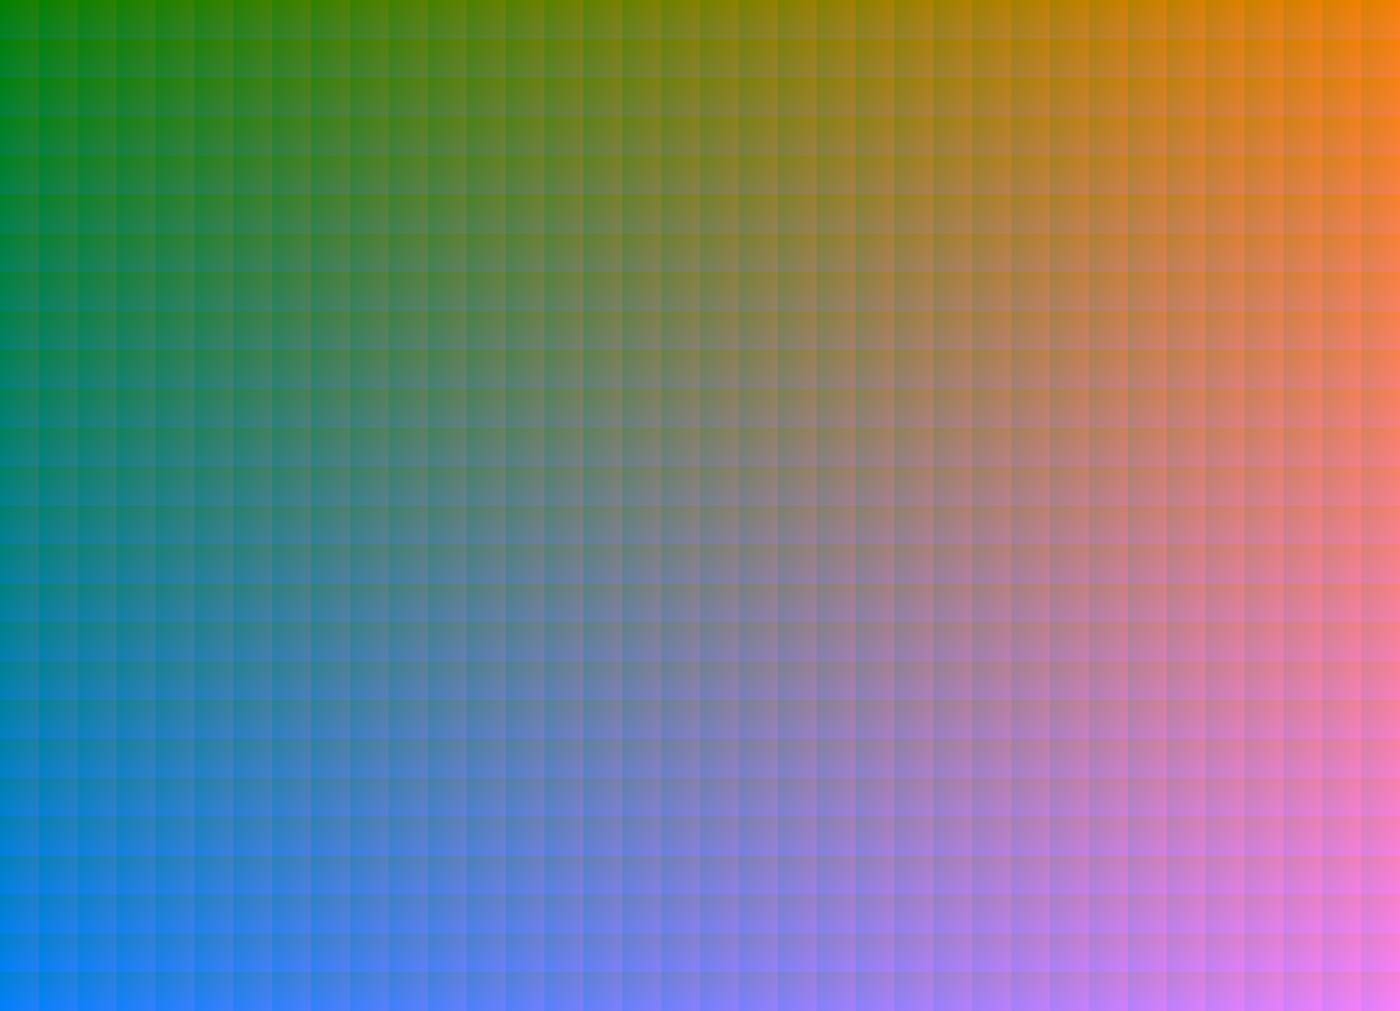

In [186]:
frankenstein = put_back_together(windows)
print("Original\t", im_pil.size)
print("Frankenstein\t", frankenstein.size)
print(f"{frankenstein.width/im_pil.width:.2%} {frankenstein.height/im_pil.height:.2%}")
view(frankenstein, 1400)